In [1]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows']

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
from flows import Flow
from flows.affine import Planar
from flows.sylvester import TriangularSylvester
from models.vae import GatedConvVAE

In [3]:
from datasource import EraiRasDataLoader

data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')

# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True)
#ras_deg116 = xr.open_zarr(rasmussen('daily-1-16deg'), consolidated=True)
# regions
def southeast_us(dataset, scale_factor=1):
    lats, lons = dataset.lat, dataset.lon
    seus_lat_st = np.abs(lats - 25).argmin().values
    seus_lat_en = seus_lat_st + 15*scale_factor
    seus_lon_st = np.abs(lons - 260).argmin().values
    seus_lon_en = seus_lon_st + 30*scale_factor
    dataset_seus = dataset.isel(lat=slice(seus_lat_st, seus_lat_en),
                                lon=slice(seus_lon_st, seus_lon_en))
    return dataset_seus

erai_deg1_seus = southeast_us(erai_deg1)
ras_deg1_seus = southeast_us(ras_deg1)
ras_deg12_seus = southeast_us(ras_deg12, scale_factor=2)
ras_deg14_seus = southeast_us(ras_deg14, scale_factor=4)
ras_deg18_seus = southeast_us(ras_deg18, scale_factor=8)

In [4]:
split_fn = data_util.create_time_series_train_test_generator(n_splits=3)

In [5]:
from utils.pipeline_v2 import Pipeline, fillnan, clip, remove_monthly_means
preprocess_maxt = Pipeline('MAXT', fillnan(0), clip(0), remove_monthly_means())
preprocess_hgt = Pipeline('HGT', fillnan(0), clip(0))

In [6]:
ras_seus_maxt_14 = preprocess_maxt(ras_deg14_seus)
ras_seus_maxt_1 = preprocess_maxt(ras_deg1_seus)
folds = list(split_fn(ras_seus_maxt_14, ras_seus_maxt_14))

In [7]:
n_layers = 6
flow = Flow.uniform(n_layers, lambda i: TriangularSylvester(flip_z = i % 2 != 0))
beta_update = lambda i, beta: 1.0E-1*i

In [8]:
def preprocess_vae(data, k=6, stride=3, n_epochs=1, batch_size=100):
    data = data_util.extract_patches(data, k=k, stride=stride, scale=1)
    batch = data.batch(batch_size)
    return tf.data.Dataset.zip((batch, batch)).repeat(n_epochs)

def preprocess_vds(data_lo, data_hi, scale=2, k=6, stride=3, n_epochs=1, batch_size=100):
    data = tf.data.Dataset.zip((data_lo, data_hi))
    #data = data_util.extract_patches(data, k=k, stride=stride, scale=[1,scale])
    batch = data.batch(batch_size)
    return batch.repeat(n_epochs)

Fold 1/3
1200 training samples, 1200 test samples, 60x120
Train for 120 steps, validate for 120 steps
Epoch 1/10
120/120 [==============================] - 59s 488ms/step - loss: 12.4895 - val_loss: 12.7198
Epoch 2/10
120/120 [==============================] - 49s 412ms/step - loss: 12.4870 - val_loss: 12.7190
Epoch 3/10
120/120 [==============================] - 49s 407ms/step - loss: 12.2410 - val_loss: 11.1903
Epoch 4/10
120/120 [==============================] - 50s 419ms/step - loss: 8.4940 - val_loss: 6.5573
Epoch 5/10
120/120 [==============================] - 48s 403ms/step - loss: 5.3856 - val_loss: 4.5596
Epoch 6/10
120/120 [==============================] - 50s 414ms/step - loss: 4.0712 - val_loss: 3.6973
Epoch 7/10
120/120 [==============================] - 51s 426ms/step - loss: 3.3383 - val_loss: 3.1525
Epoch 8/10
120/120 [==============================] - 49s 409ms/step - loss: 3.0018 - val_loss: 2.9088
Epoch 9/10
120/120 [==============================] - 50s 413ms/step

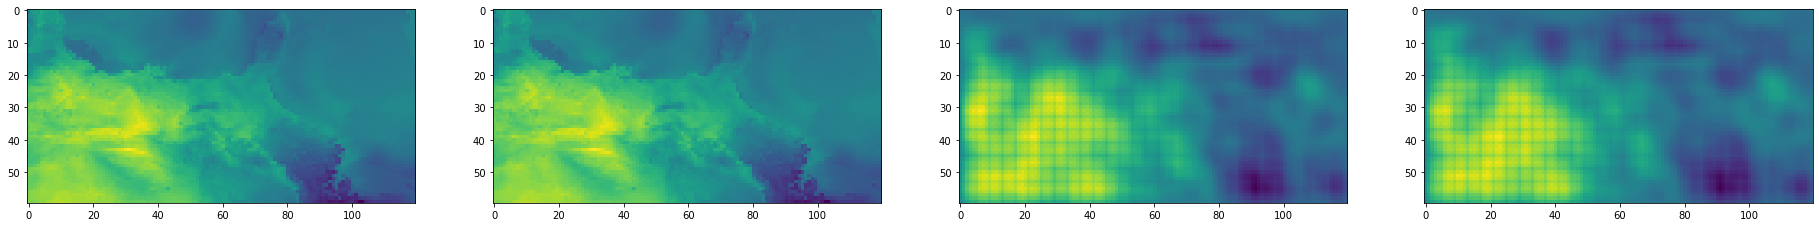

Fold 2/3
2400 training samples, 2400 test samples, 60x120
Train for 240 steps, validate for 240 steps
Epoch 1/10
240/240 [==============================] - 104s 435ms/step - loss: 12.5169 - val_loss: 10.8248
Epoch 2/10
240/240 [==============================] - 99s 413ms/step - loss: 7.4237 - val_loss: 4.4759
Epoch 3/10
240/240 [==============================] - 97s 404ms/step - loss: 3.6480


KeyboardInterrupt: 

In [9]:
k, stride = 16, 4
sample_batch_size = 10
load_batch_size = 1200
n_epochs = 10
for i, ((train_lo, train_hi), (test_lo, test_hi)) in enumerate(folds):
    print(f'Fold {i+1}/{len(folds)}')
    N_train, N_test = train_lo.Time.size, train_lo.Time.size
    wt, ht = train_lo.shape[1], train_lo.shape[2]
    print('{} training samples, {} test samples, {}x{}'.format(N_train, N_test, wt, ht))
    #batch_multiplier = data_util.calculate_n_subimages(train_lo, k, stride)
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size)
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, k=k, stride=stride, n_epochs=n_epochs, batch_size=sample_batch_size)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, k=k, stride=stride, n_epochs=n_epochs, batch_size=sample_batch_size)
    vae = GatedConvVAE(wt, ht, flow, hidden_units=64, encoder_strides=[2,2], decoder_strides=[2,2], z_size=32,
                       beta_update_fn=beta_update, output_activation='linear', loss='mse')
    vae.fit(train_ds, epochs=n_epochs, steps_per_epoch=train_steps,
            validation_data=test_ds, validation_steps=test_steps)
    pred = vae.predict(test_lo_ds.batch(1))
    sample = vae.sample(next(test_lo_ds.batch(1).__iter__()))
    plt.figure(figsize=(4*8,6))
    plt.subplot(1,4,1)
    plt.imshow(next(test_ds.__iter__())[0].numpy()[0].squeeze())
    plt.subplot(1,4,2)
    plt.imshow(next(test_ds.__iter__())[1].numpy()[0].squeeze())
    plt.subplot(1,4,3)
    plt.imshow(pred[0].squeeze())
    plt.subplot(1,4,4)
    plt.imshow(sample[0].squeeze())
    plt.show()